# 1. Data Processing - Population Data, Create Grids
___
### HRSL Population data (.CSV) transformation to 500m by 500m grid GeoJson

##### Import needed libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, LineString, Polygon, shape
import math
import seaborn as sns
import requests
import json

### Lagos Wards
data available on the link https://grid3.gov.ng/dataset/lagos-operational-ward-boundaries#

To Download: https://geoserver.grid3.gov.ng/geoserver/GRIDMaster/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GRIDMaster:u_boundary_wards&outputFormat=application%2Fjson&CQL_FILTER=state_code%3D%27LA%27

In [2]:
lagos_ward = gpd.read_file("./data/Lagos_wards.geojson")

<AxesSubplot:>

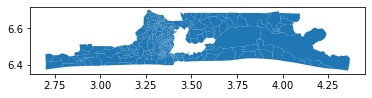

In [3]:
lagos_ward.plot()

#### Extract the extent of Lagos so the Nigeria population data can be reduce to the bounding box of Lagos


In [4]:
extent = lagos_ward.total_bounds
extent

array([2.6988308, 6.3678255, 4.3686295, 6.7004372])

### HRSL Population Datasets

All 6 data files are available on the Humanitarian Data Exchange
Link: https://data.humdata.org/dataset/highresolutionpopulationdensitymaps-nga

If the links are not working, try to download them

In [5]:
links =  {
    'total' : 'https://data.humdata.org/dataset/62ec6c48-2f23-476b-8c1e-e924ad79908d/resource/ec1ac1b2-616e-43a7-ba8c-29eaf3479f24/download/nga_general_2020_csv.zip',
    'u5' : 'https://data.humdata.org/dataset/62ec6c48-2f23-476b-8c1e-e924ad79908d/resource/bf7f28a8-e49a-4d2a-99e4-354bc783eb6d/download/nga_children_under_five_2020_csv.zip',
    '60+' : 'https://data.humdata.org/dataset/62ec6c48-2f23-476b-8c1e-e924ad79908d/resource/e5006c78-ee45-4ec5-866b-edf22e07ccb0/download/nga_elderly_60_plus_2020_csv.zip',
    'men' : 'https://data.humdata.org/dataset/62ec6c48-2f23-476b-8c1e-e924ad79908d/resource/56b75eea-196a-4597-a561-77d1e226a5de/download/nga_men_2020_csv.zip',
    'women' : 'https://data.humdata.org/dataset/62ec6c48-2f23-476b-8c1e-e924ad79908d/resource/5c5a2da6-3f3f-4376-8cfc-15dc49e7be28/download/nga_women_2020_csv.zip',
    '15-24' : 'https://data.humdata.org/dataset/62ec6c48-2f23-476b-8c1e-e924ad79908d/resource/46523605-752f-4084-bd6f-f12c5cb11f28/download/nga_youth_15_24_2020_csv.zip', 
}

## INDEX need to be set manually based on which population file should be processed!
values: 0 - 5

In [6]:
INDEX = 0

### Population Grid Size

Define the size of the grids in meters

In [10]:
grid_size = 500

In [11]:
## FB nigeria Pop data read
df_pop = pd.read_csv(list(links.values())[INDEX])

In [12]:
## Filter of Lagos
df_pop.head(3)

,longitude,latitude,nga_general_2020
0,2.477222,14.0,16.599508
1,2.477500,14.0,16.599508
2,2.477778,14.0,16.599508


### Filter for population data in the Lagos bounding box and areas

In [15]:
df_lagos_pop = df_pop[(df_pop.longitude >= extent[0]) & (df_pop.longitude <= extent[2]) & (df_pop.latitude >= extent[1]) & (df_pop.latitude <= extent[3])]

In [16]:
## For memory efficency purposes
del df_pop

In [17]:
### Transform to GeoPandas Dataframe
lagos_pop = gpd.GeoDataFrame(df_lagos_pop, geometry=gpd.points_from_xy(df_lagos_pop.longitude, df_lagos_pop.latitude), crs='EPSG:4326')

In [18]:
## filter down more to the shapes 
lagos_pop = gpd.sjoin(lagos_pop, lagos_ward,op="within", how='left')
lagos_pop.dropna(subset=['ward_code'], inplace=True)

In [38]:
## The name of the population attribute is depending on the selected pop data loaded in, but alwasy the 3th column
pop_attr = lagos_pop.columns[2]

In [39]:
## Pop of ward
#lagos_ward = pd.merge(lagos_ward, lagos_pop.groupby('ward_code').agg({ pop_attr:'sum'}), on='ward_code')

### Covert to meters 

In [21]:
## Convert To Meters - grid size in meters, therefore it needs to be converted
lagos_pop = lagos_pop.to_crs('EPSG:3857')

In [22]:
lagos_pop['lat_m']  = lagos_pop.geometry.x
lagos_pop['lng_m']  = lagos_pop.geometry.y

In [23]:
## coords in meters saved no we convert back
lagos_pop = lagos_pop.to_crs('EPSG:4326')

### Calculate the population within the grids
The calcualtion done by rounding down the coords (in meters) to the closest 500 

In [24]:
lagos_pop[['grid_x', 'grid_y']] = np.floor(lagos_pop[['lat_m', 'lng_m']] / grid_size).astype(int) * grid_size

In [25]:
## Defined grid ID is the left, bottom coords of the squares

lagos_pop['grid_id'] = lagos_pop['grid_x'].astype(str) + "_" +  lagos_pop['grid_y'].astype(str)  

In [26]:
lagos_pop_grid = lagos_pop.groupby('grid_id').agg({ pop_attr:'sum', 'grid_x' : 'first', 'grid_y' : 'first', 'ward_name' : 'first'})

In [27]:
lagos_pop_grid.head(3)

,nga_general_2020,grid_x,grid_y,ward_name
grid_id,,,,
300500_711000,1103.546013,300500,711000,Gbethrome
300500_711500,1580.077246,300500,711500,Gbethrome
300500_712000,1805.802567,300500,712000,Gbethrome


In [28]:
## define the geometry, we only have the bottom left coords but by adding 500 to those can give us the other corners of the squares
lagos_pop_grid['geometry'] = lagos_pop_grid.apply(lambda x : Polygon([ [x.grid_x, x.grid_y], [x.grid_x + grid_size, x.grid_y],  [x.grid_x + grid_size, x.grid_y + grid_size], [x.grid_x, x.grid_y + 500]]) , axis=1)

In [32]:
# Transform to GeoDF - crs in meters
lagos_pop_grid = gpd.GeoDataFrame(lagos_pop_grid, crs="EPSG:3857")

5634


<AxesSubplot:>

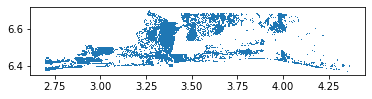

In [36]:
#Check how many grids has been created and plot it
print(len(lagos_pop_grid))
lagos_pop_grid.plot()

In [35]:
## Transform back to WSG 84 - lng lat in degrees
lagos_pop_grid = lagos_pop_grid.to_crs('EPSG:4326')

#### Save the Selected and  Transformed File

In [64]:
lagos_pop_grid.to_file(f"./data/lagos_grid_pop_{list(links.keys())[INDEX]}.geojson", driver='GeoJSON')

### The INDEX value needs to be change to rerun the process for the other population files
___

# Merge them together
Only when you've done it for all 6 population data files

In [7]:
lagos_pop_grid_total = gpd.read_file("./data/lagos_grid_pop_total.geojson", driver='GeoJSON')
lagos_pop_grid_u5 = gpd.read_file("./data/lagos_grid_pop_u5.geojson", driver='GeoJSON')
lagos_pop_grid_men = gpd.read_file("./data/lagos_grid_pop_men.geojson", driver='GeoJSON')
lagos_pop_grid_women = gpd.read_file("./data/lagos_grid_pop_women.geojson", driver='GeoJSON')
lagos_pop_grid_60 = gpd.read_file("./data/lagos_grid_pop_60+.geojson", driver='GeoJSON')
lagos_pop_grid_15_24 = gpd.read_file("./data/lagos_grid_pop_15-24.geojson", driver='GeoJSON')

In [8]:
lagos_pop_grid = pd.merge(lagos_pop_grid_total,  lagos_pop_grid_u5[ lagos_pop_grid_u5.columns[:2]], on="grid_id")

In [9]:
lagos_pop_grid = pd.merge(lagos_pop_grid, lagos_pop_grid_men[lagos_pop_grid_men.columns[:2]], on="grid_id")

In [10]:
lagos_pop_grid = pd.merge(lagos_pop_grid, lagos_pop_grid_women[lagos_pop_grid_women.columns[:2]], on="grid_id")

In [11]:
lagos_pop_grid = pd.merge(lagos_pop_grid, lagos_pop_grid_60[lagos_pop_grid_60.columns[:2]], on="grid_id")

In [12]:
lagos_pop_grid = pd.merge(lagos_pop_grid, lagos_pop_grid_15_24[lagos_pop_grid_15_24.columns[:2]], on="grid_id")

In [91]:
lagos_pop_grid.to_file("./data/lagos_grid_pop.geojson", driver='GeoJSON')